In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

file_path = r'C:\Users\Asus\Effective_Climate_Factors.csv'
df1 = pd.read_csv(file_path)
df1['year'] = df1['year'].str.replace(',', '')
df1['date'] = df1['year'].astype(str) + ',' + df1['month'] + '-' + df1['day'].astype(str)
df1['date'] = pd.to_datetime(df1['date'], format='%Y,%b-%d')
df1=df1.set_index(df1['date'])
df1=df1[['t_mean','t_min','t_max','rain','snow','ww_max']]
columns_to_convert=['t_mean','t_min','t_max','rain','snow','ww_max']
df1[columns_to_convert] = df1[columns_to_convert].apply(pd.to_numeric, errors='coerce').fillna(0)
new_column_names = {
    't_mean': 'mean_temperature',
    't_min': 'min_temperature',
    't_max': 'max_temperature',
    'rain': 'precipitation_rain',
    'snow': 'precipitation_snow',
    'ww_max': 'max_wind_speed'
}

def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return z_scores > threshold

df1 = df1.rename(columns=new_column_names)
df1.head()

,mean_temperature,min_temperature,max_temperature,precipitation_rain,precipitation_snow,max_wind_speed
date,,,,,,
1951-01-01,3.1,2.0,9.0,0.0,0.0,3.0
1951-01-02,1.8,-3.0,8.0,0.0,0.0,3.0
1951-01-03,2.4,-2.0,8.0,19.0,0.0,71.0
1951-01-04,2.5,2.0,4.0,1.0,0.0,44.0
1951-01-05,-0.1,0.0,2.0,5.0,0.0,71.0


In [2]:
file_path = r'C:\Users\Asus\Urmia_Lake_Water_Level_Dataset.csv'
df2 = pd.read_csv(file_path)
df2['date'] = df2['Date\n(Gregorian callendar)']
df2['date'] = pd.to_datetime(df2['date'], format='%m/%d/%Y')
df2=df2.set_index(df2['date'])
df2=df2[['Water Level\n(m above sea level)']]
df2=df2.rename(columns={'Water Level\n(m above sea level)':'water_level'})
df2.head()

,water_level
date,
1965-11-24,1273.82
1965-11-25,1273.82
1965-11-26,1273.83
1965-11-27,1273.83
1965-11-28,1273.82


In [3]:
intersection_df = df1.merge(df2, on='date', how='inner')
intersection_df

,mean_temperature,min_temperature,max_temperature,precipitation_rain,precipitation_snow,max_wind_speed,water_level
date,,,,,,,
1965-11-24,6.2,-1.0,13.0,0.0,0.0,3.0,1273.82
1965-11-25,6.9,1.0,14.0,0.0,0.0,2.0,1273.82
1965-11-26,7.5,-1.0,15.0,0.0,0.0,21.0,1273.83
1965-11-27,6.3,8.0,10.0,2.0,0.0,80.0,1273.83
1965-11-28,3.4,-2.0,8.0,0.0,0.0,3.0,1273.82
...,...,...,...,...,...,...,...
2012-03-15,7.0,5.2,11.0,3.0,0.0,80.0,1271.01
2012-03-16,1.4,3.4,4.4,2.3,0.0,85.0,1271.02
2012-03-17,-5.1,-7.8,-3.2,5.0,13.0,75.0,1271.01


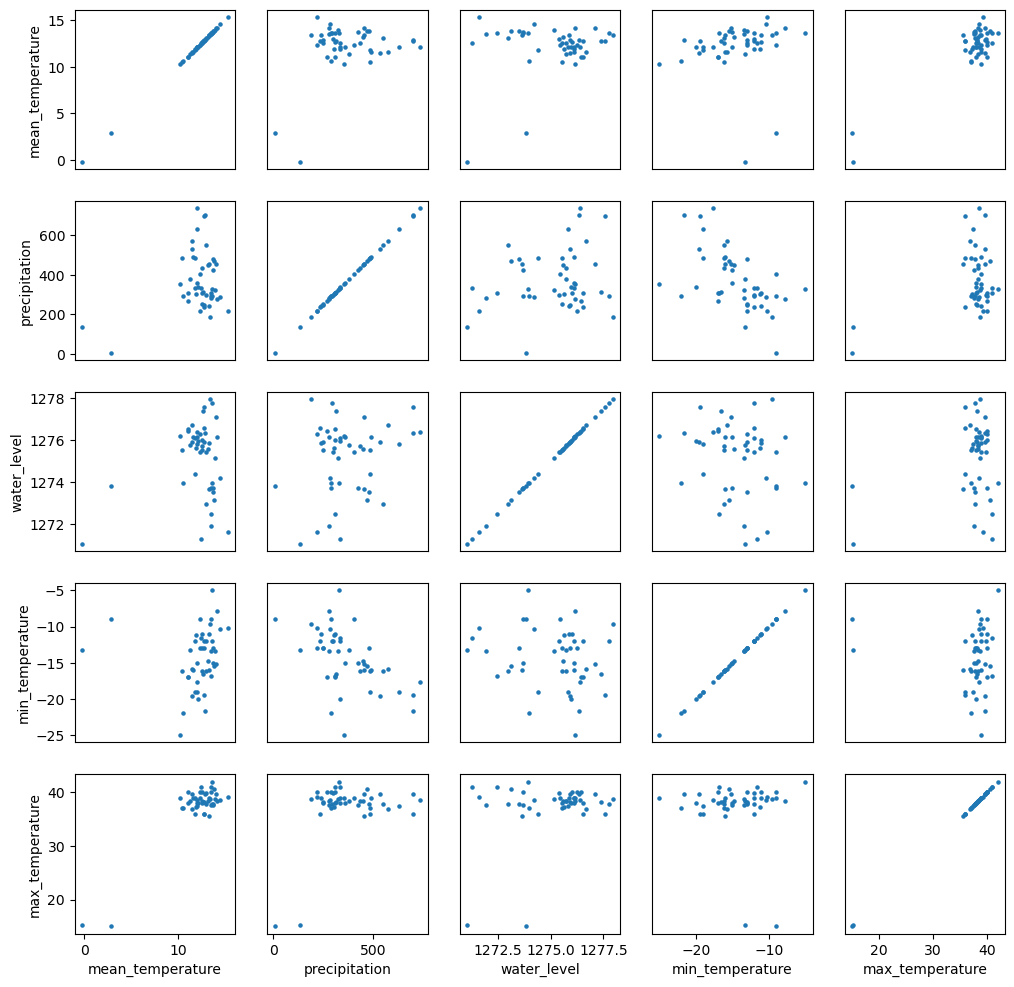

In [4]:
intersection_df['precipitation'] = intersection_df['precipitation_rain'] + intersection_df['precipitation_snow']
groupped_df = intersection_df.groupby(intersection_df.index.to_period('Y')).agg(
    {'precipitation': 'sum', 'mean_temperature': 'mean', 'water_level': 'mean','min_temperature':'min','max_temperature':'max'}
).reset_index()

cols = ['mean_temperature','precipitation','water_level','min_temperature','max_temperature']
fig, axs = plt.subplots(len(cols), len(cols), figsize=(12,12))
for i in range(len(cols)):
    for j in range(len(cols)):
        axs[i,j].scatter(groupped_df[cols[j]], groupped_df[cols[i]], s=5)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        if i == len(cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(cols[j])
        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(cols[i])


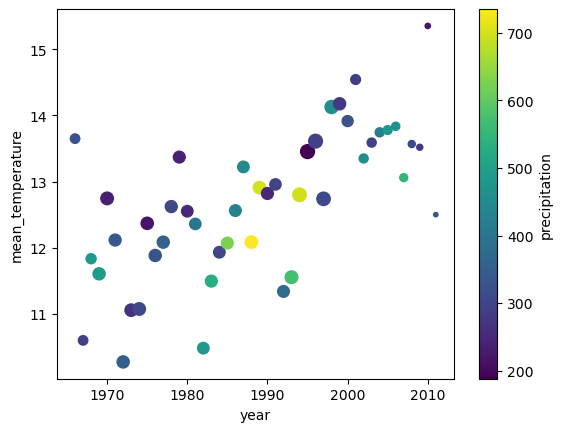

In [5]:
groupped_df['year'] = groupped_df['date'].dt.year
groupped_df=groupped_df.iloc[1:-1]
min_water_level = groupped_df['water_level'].min()
max_water_level = groupped_df['water_level'].max()
normalized_water_level = (
    10 + (groupped_df['water_level'] - min_water_level) * (100 - 10) / (max_water_level - min_water_level)
)
ax1=groupped_df.plot.scatter( 'year','mean_temperature', c='precipitation',s=normalized_water_level, colormap='viridis')
colorbar=ax1.collections[0].colorbar


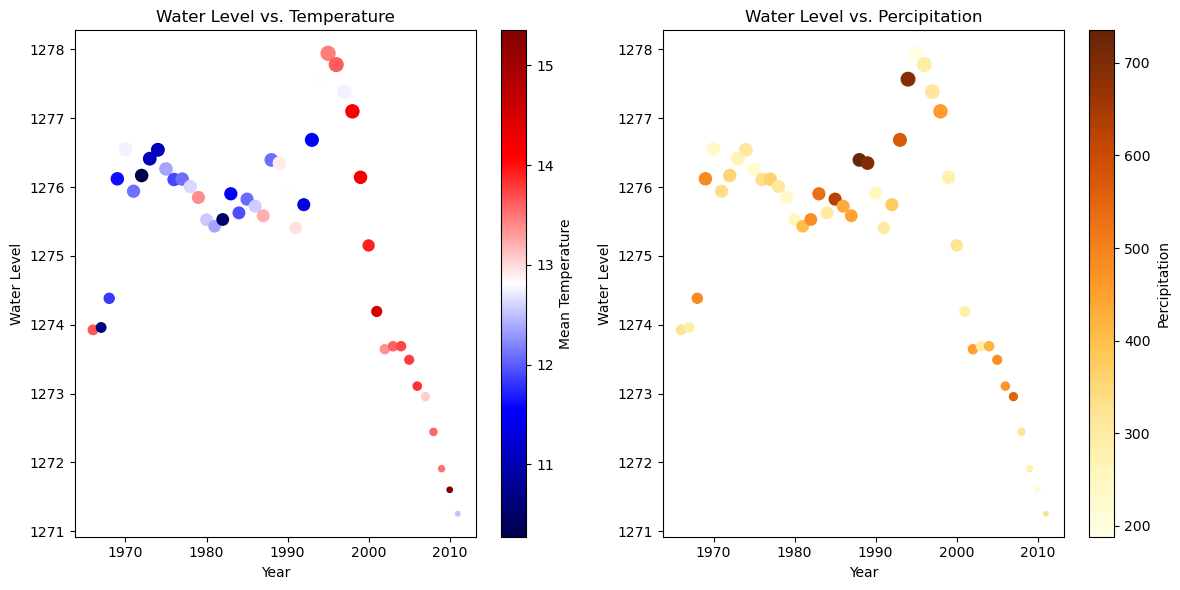

In [6]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1=groupped_df.plot.scatter('year', 'water_level', c='mean_temperature',s=normalized_water_level, colormap='seismic', ax=ax1)
colorbar=ax1.collections[0].colorbar
colorbar.set_label('Mean Temperature')
ax1.set_title('Water Level vs. Temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Water Level')

ax2=groupped_df.plot.scatter('year', 'water_level', c='precipitation',s=normalized_water_level, colormap='YlOrBr', ax=ax2);
colorbar=ax2.collections[0].colorbar
colorbar.set_label('Percipitation')
ax2.set_title('Water Level vs. Percipitation')
ax2.set_xlabel('Year');
ax2.set_ylabel('Water Level');
plt.tight_layout()
plt.show()